In [6]:
import os
import sys

data_fitting_py_files_dir = os.path.abspath("../py_files/")
sys.path.insert(0, data_fitting_py_files_dir)

helper_func_py_files_dir = os.path.abspath("../../../vampires_on_sky_calibration/programs/py_files/")
sys.path.insert(0, helper_func_py_files_dir)

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import general
import data_plotting
import reading_data
import instrument_matrices

# Start-Up Information

In [7]:
HWP_angs = np.array([0., 11.25, 22.5, 33.75, 45., 56.25, 67.5, 78.75])
IMR_angs = np.array([45., 57.5, 70., 82.5, 95., 107.5, 120., 132.5])
wavelengths = np.array([625, 675, 725, 750, 775])
angles = [HWP_angs, IMR_angs]

In [8]:
# Last index is for choosing the wavelength

wavelength_index = 1
wavelength = 675

double_differences = np.load("../../data/20220428/double_difference_new_darks_median_grid.npy")[:, :, wavelength_index]
double_sums = np.load("../../data/20220428/double_sum_new_darks_median_grid.npy")[:, :, wavelength_index]
double_difference_errs = np.load("../../data/20220428/double_difference_sem_new_darks_median_grid.npy")[:, :, wavelength_index]
double_sum_errs = np.load("../../data/20220428/double_sum_sem_new_darks_median_grid.npy")[:, :, wavelength_index]
data = np.array([double_differences, double_sums])
stds = np.array([double_difference_errs, double_sum_errs])

print(np.shape(data))

reshaped_data = general.reshape_and_flatten(data)
reshaped_stds = general.reshape_and_flatten(stds)

(2, 8, 8)


# Setting Parameter Bounds & Guesses

In [9]:
# NOTE: Customized angle bounds for each parameter
IMR_angle_bound = 1
LP_angle_bound = 5
HWP_angle_bound = 5
FLC_angle_bound = (-5, 5)

model = instrument_matrices.full_system_mueller_matrix

bounds = ((0, 1), # EM Gain Ratio
          (-1 * LP_angle_bound, LP_angle_bound), # linear polarizer angle (degrees)
          (-1, 1), # delta_FLC (waves)
          (-1, 1), # delta_opt (waves)
          (-1, 1), # delta_derot (waves)
          (0, 0.5), # delta_HWP (waves)
          FLC_angle_bound, # rot_FLC (degrees)
          (-90, 90), # rot_opt (degrees)
          (-1 * IMR_angle_bound, IMR_angle_bound), # offset_derot (degrees)
          (-1 * HWP_angle_bound, HWP_angle_bound), # offset_HWP (degrees)
          (0, 1)) # epsilon_opt (unitless)

# Ordering of parameters
# em_gain, pol_theta, delta_FLC, delta_opt, delta_derot, delta_HWP, rot_FLC, 
# rot_opt, offset_derot, offset_HWP, epsilon_opt, angles


In [13]:
data_dir = "../../data/20220428/"
wavelength = 675
filepath = data_dir + str(wavelength) + \
    "nm_0_FLC_Angle_1_Degree_Bound_IMR_5_Deg_Others_Recursive_Guesses_Eta_Crv_EM_Gain.npy"

np.save(filepath, np.array([ \
    -3.7768300814382085, # theta_pol
    0.451,  # delta_HWP
    -2.642,  # offset_HWP
    0.32, # delta_derot
    -0.011,  # offset_derot
    -0.163 , # delta_opts
    0.036,  # epsilon_opts
    -7.151,  # rot_opts
    0.302,  # delta_FLC
    0.256, # rot_FLC
]))

np.load(filepath)

# initial_guess = np.load(data_dir + str(wavelength) + \
#     "_0_FLC_Angle_1_Degree_Bound_IMR_5_Deg_Others_Recursive_Guesses_Eta_Crv_EM_Gain.npy")

array([-3.77683008,  0.451     , -2.642     ,  0.32      , -0.011     ,
       -0.163     ,  0.036     , -7.151     ,  0.302     ,  0.256     ])

# Plot Initial Guess

(128,)


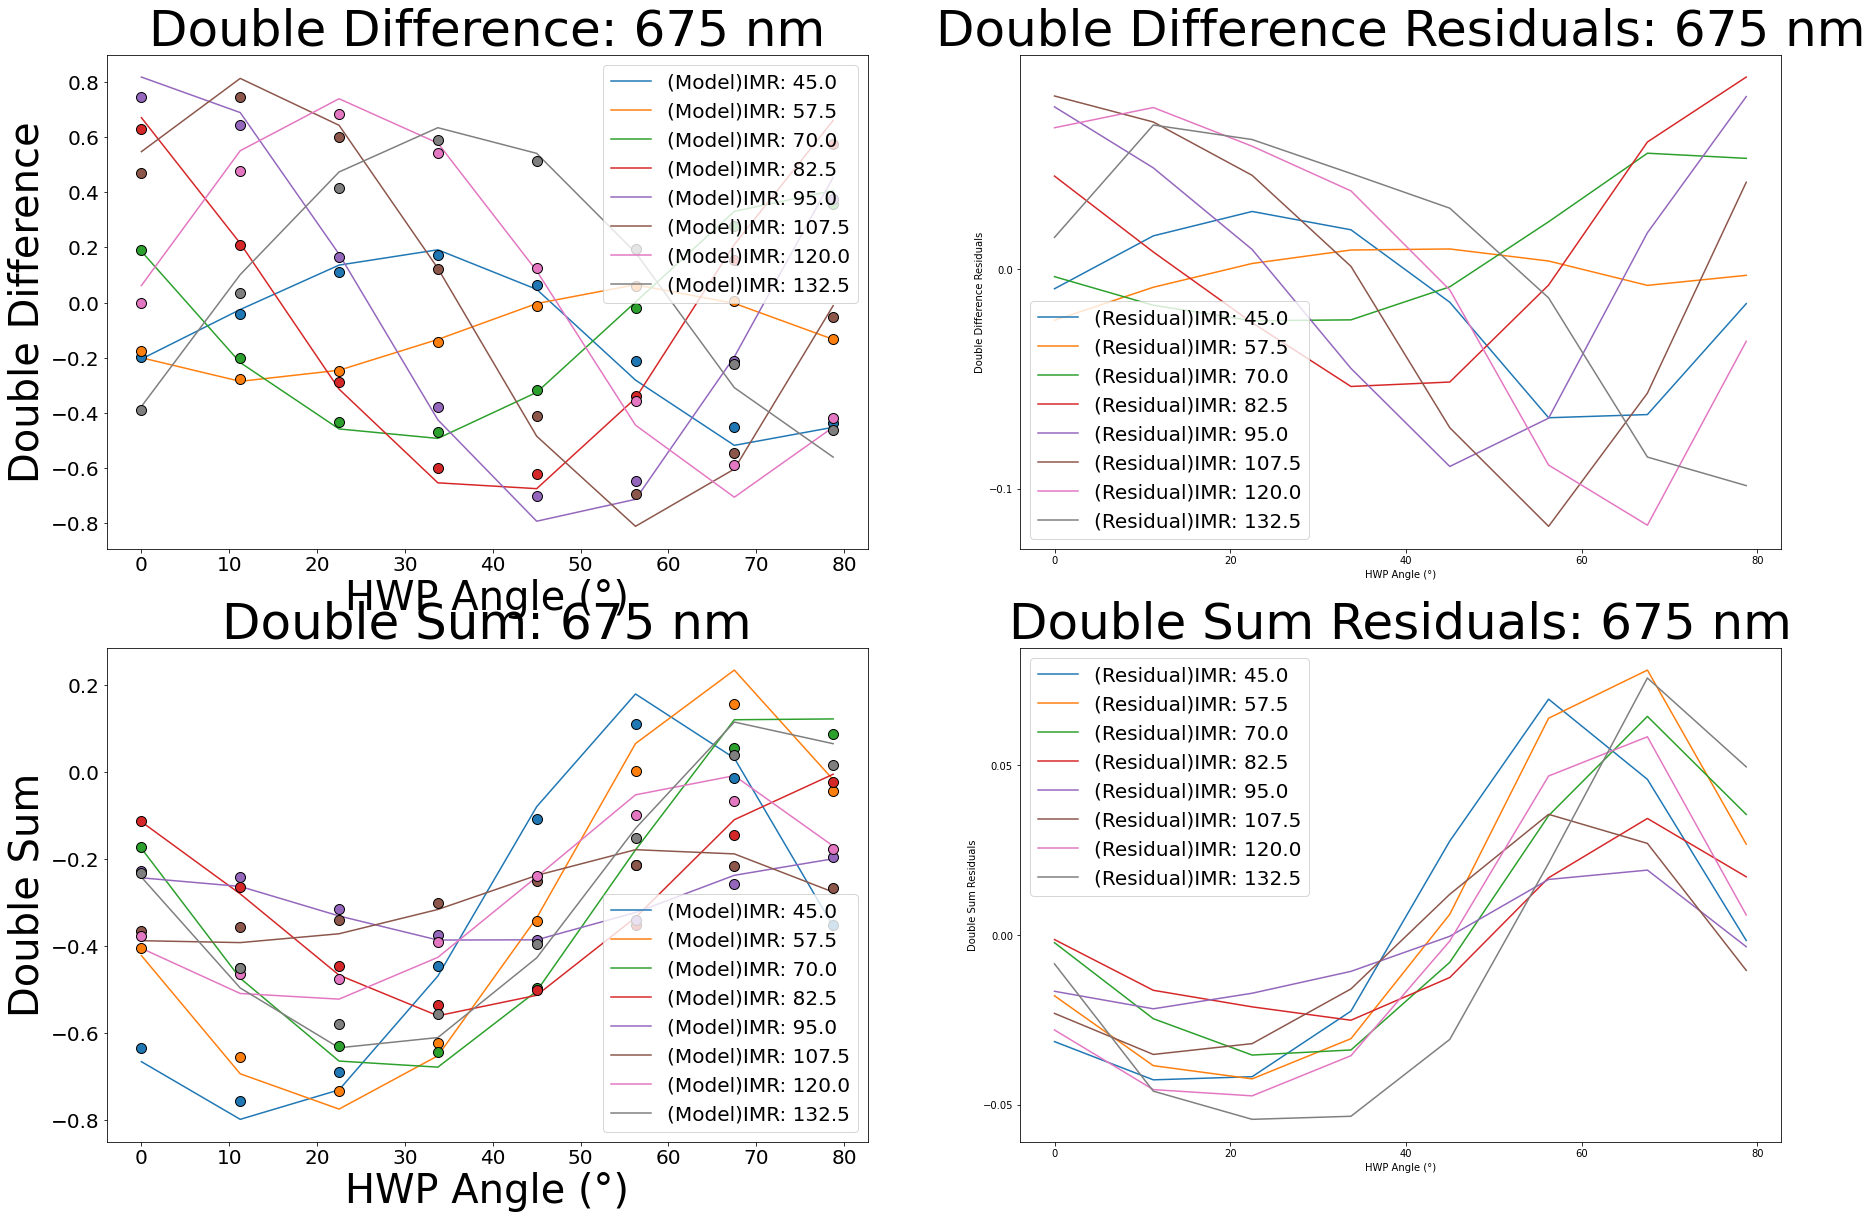

In [5]:
# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

# # Defining lambda function
# nll = lambda *args: MCMC_SetUp.likelihood_linear_polarizer_residuals(*args)

# # List to store all the solutions 
# solns = []

# [ 0.44803965 -3.77683008  0.32872561 -0.14961975  0.32208685  0.45649444
#   1.5231767  -2.39509122  1.         -2.46183143  0.01868704]

# initial_guess = np.array([
#                     0.416, # EM gain ratio
#                     0, # pol_theta (degrees)
#                     0.237, # FLC_retardance (waves)
#                     -0.254, # Optics_retardance (waves)
#                     0.321, # IMR_retardance (waves)
#                     0.451, # HWP_retardance (waves)
#                     0, # FLC_angle (degrees)
#                     -17.143, # Optics_angle (degrees)
#                     0, # IMR_offset (degrees)
#                     0, # HWP_offset (degrees)
#                     0.05]) # Optics_diatteuation

initial_guess = np.array([ \
    -3.7768300814382085, # theta_pol
    0.451,  # delta_HWP
    -2.642,  # offset_HWP
    0.32, # delta_derot
    -0.011,  # offset_derot
    -0.163 , # delta_opts
    0.036,  # epsilon_opts
    -7.151,  # rot_opts
    0.302,  # delta_FLC
    0.256, # rot_FLC
])

# Trying the values from 1 degree bound IMR 5 degree others recursive notebook
# theta_pol = -3.7768300814382085
# delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
# epsilon_m3 = 0 # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
# offset_m3 = 0 # NOTE: Made this zero too for testing purposes
# em_gain = 0.44803965482698693  # Add your actual em_gain value
# delta_HWP = 0.45649443676091783  # Add your actual delta_HWP value
# offset_HWP = -2.461831433780967  # Add your actual offset_HWP value
# delta_derot = 0.32208684844990476  # Add your actual delta_derot value
# offset_derot = 1  # Add your actual offset_derot value
# delta_opts = -0.14961975453168286  # Add your actual delta_opts value
# epsilon_opts = 0.01868703913240439  # Add your actual epsilon_opts value
# rot_opts = -2.3950912229452315  # Add your actual rot_opts value
# delta_FLC = 0.3287256097107294  # Add your actual delta_FLC value
# rot_FLC = 1.5231767001488516  # Add your actual rot_FLC value

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits - having zeros for angles that're too large
theta_pol = -3.7768300814382085
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing specific parameters
# epsilon_m3 = epsilon_m3 / 1
# em_gain = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

initial_model = instrument_matrices.internal_calibration_mueller_matrix(theta_pol,
    model, fixed_params, HWP_angs, IMR_angs)

print(np.shape(initial_model))

initial_residuals = initial_model - reshaped_data

data_plotting.plot_single_model_and_residuals(angles, angles, initial_model, data, 
    initial_residuals, stds, log_f, wavelength, fig_dimensions = (30, 20))

# Fitting for all parameters by the EM Gain

In [6]:
import numpy as np
from scipy.optimize import minimize

# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

# List to store all the solutions 
solns = []

# Initial values
theta_pol = -3.7768300814382085
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value
em_gain = 1 / 1.1342789620513443 # From looking at unpol standards fluxes

# Initial guess based on the parameters you want to minimize
initial_guess = np.array([theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, 
    delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC])

all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Fixed parameters not included in the fitting process
fixed_params = [delta_m3, epsilon_m3, offset_m3, em_gain]

# Define the bounds for the parameters (excluding em_gain)
bounds = [
    (-5, 5),  # theta_pol
    (0, 0.5),  # delta_HWP
    (-5, 5),  # offset_HWP
    (0, 0.5),  # delta_derot
    (-5, 5),  # offset_derot
    (-0.5, 0.5),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    (0, 0.5),  # delta_FLC
    (-90, 90)  # rot_FLC
]

# Defining the negative log-likelihood function
def nll(params, model, HWP_angs, IMR_angs, data, stds):
    theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC = params
    delta_m3, epsilon_m3, offset_m3, em_gain = fixed_params
    all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
        rot_FLC, em_gain]
    this_model = instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)
    residuals = this_model - data
    
    # Debug print shapes
    # print("Model shape:", this_model.shape)
    # print("Data shape:", data.shape)
    # print("Stds shape:", stds.shape)
    
    likelihood = np.sum((residuals / stds) ** 2)
    return likelihood

# Initialize variables for the iterative minimization process
counter = 0
initial_likelihood = 100
post_likelihood = 90

# Starting off with the initial guess
model = instrument_matrices.full_system_mueller_matrix
initial_model = instrument_matrices.internal_calibration_mueller_matrix(initial_guess[0], model, all_params, HWP_angs, IMR_angs)

while post_likelihood < initial_likelihood:
    counter += 1

    initial_likelihood = post_likelihood

    # Calculate the initial model and residuals
    initial_model = instrument_matrices.internal_calibration_mueller_matrix(initial_guess[0], model, all_params, HWP_angs, IMR_angs)
    initial_residuals = initial_model - reshaped_data

    initial_likelihood = np.sum((initial_residuals / reshaped_stds) ** 2)

    print("Initial Likelihood: " + str(initial_likelihood))

    # Minimize the negative log-likelihood
    minimize_args = (model, HWP_angs, IMR_angs, reshaped_data, reshaped_stds)
    soln = minimize(nll, initial_guess, args=minimize_args, bounds=bounds, method="Nelder-Mead")

    # Save the solution
    solns.append(soln)

    # Recalculate the likelihood with the new solution
    theta_pol, delta_HWP, offset_HWP, delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC = soln.x
    delta_m3, epsilon_m3, offset_m3, em_gain = fixed_params
    all_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
        rot_FLC, em_gain]
    post_likelihood = np.sum((instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs) - reshaped_data) / reshaped_stds ** 2)

    print("Iteration #" + str(counter) + ": " + str(post_likelihood))

    print("MAXIMUM LIKELIHOOD ESTIMATES")
    print("")
    print("theta_pol (degrees): " + str(theta_pol))
    print("delta_HWP (waves): " + str(delta_HWP))
    print("offset_HWP (degrees): " + str(offset_HWP))
    print("delta_derot (waves): " + str(delta_derot))
    print("offset_derot (degrees): " + str(offset_derot))
    print("delta_opts (waves): " + str(delta_opts))
    print("epsilon_opts: " + str(epsilon_opts))
    print("rot_opts (degrees): " + str(rot_opts))
    print("delta_FLC (waves): " + str(delta_FLC))
    print("rot_FLC (degrees): " + str(rot_FLC))

    reshaped_data = general.reshape_and_flatten(data)
    reshaped_stds = general.reshape_and_flatten(stds)

    model_1 = instrument_matrices.internal_calibration_mueller_matrix(theta_pol, model, all_params, HWP_angs, IMR_angs)
    residuals_1 = model_1 - reshaped_data

    # data_plotting.plot_single_model_and_residuals(angles, angles, model_1, data, 
    #     residuals_1, stds, log_f, wavelength, fig_dimensions = (30, 20))

    # Reset initial guess
    initial_guess = soln.x

    print("Post Likelihood: " + str(post_likelihood))


Initial Likelihood: 12195858.305439405
Iteration #1: 29530355.595081933
MAXIMUM LIKELIHOOD ESTIMATES

theta_pol (degrees): 4.834912535187302
delta_HWP (waves): 0.4999999999954652
offset_HWP (degrees): 2.4964807938720286
delta_derot (waves): 0.31629554624223233
offset_derot (degrees): -0.16551336132395994
delta_opts (waves): -0.18281008183974135
epsilon_opts: 0.0
rot_opts (degrees): -8.675291876184012
delta_FLC (waves): 0.31720942351917025
rot_FLC (degrees): -3.694378484856337
Post Likelihood: 29530355.595081933


In [7]:
print(all_params[1 :])
print(soln.x)

[0, 0, 0.4999999999954652, 2.4964807938720286, 0.31629554624223233, -0.16551336132395994, -0.18281008183974135, 0.0, -8.675291876184012, 0.31720942351917025, -3.694378484856337, 0.8816173388171631]
[ 4.83491254  0.5         2.49648079  0.31629555 -0.16551336 -0.18281008
  0.         -8.67529188  0.31720942 -3.69437848]


# Plot Final Likelihood

(128,)
[ 4.83491254  0.5         2.49648079  0.31629555 -0.16551336 -0.18281008
  0.         -8.67529188  0.31720942 -3.69437848]
[-1.58264520e-01  6.34415292e-02  2.47609815e-01  2.92270230e-01
  1.64403643e-01 -6.75125374e-02 -2.60275438e-01 -2.94724045e-01
 -1.12893221e-01 -2.01175693e-01 -1.72618467e-01 -4.49511544e-02
  1.13212589e-01  2.10575164e-01  1.83615876e-01  4.68637060e-02
  2.72280720e-01 -8.86047283e-02 -3.86090799e-01 -4.57794766e-01
 -2.65440120e-01  8.99289456e-02  4.04439768e-01  4.81664608e-01
  6.99579820e-01  3.38277476e-01 -2.10187330e-01 -6.26087417e-01
 -6.78602694e-01 -3.35799336e-01  2.14442856e-01  6.48843926e-01
  8.19815538e-01  7.60281267e-01  2.56945298e-01 -3.90850439e-01
 -8.08165250e-01 -7.55028954e-01 -2.58106424e-01  3.96086994e-01
  5.15677138e-01  8.42123619e-01  6.77004502e-01  1.15612419e-01
 -5.18237462e-01 -8.51840640e-01 -6.84678893e-01 -1.16130175e-01
 -2.47278687e-02  4.99350711e-01  7.29100820e-01  5.36791515e-01
  2.49159543e-02 -5.13919

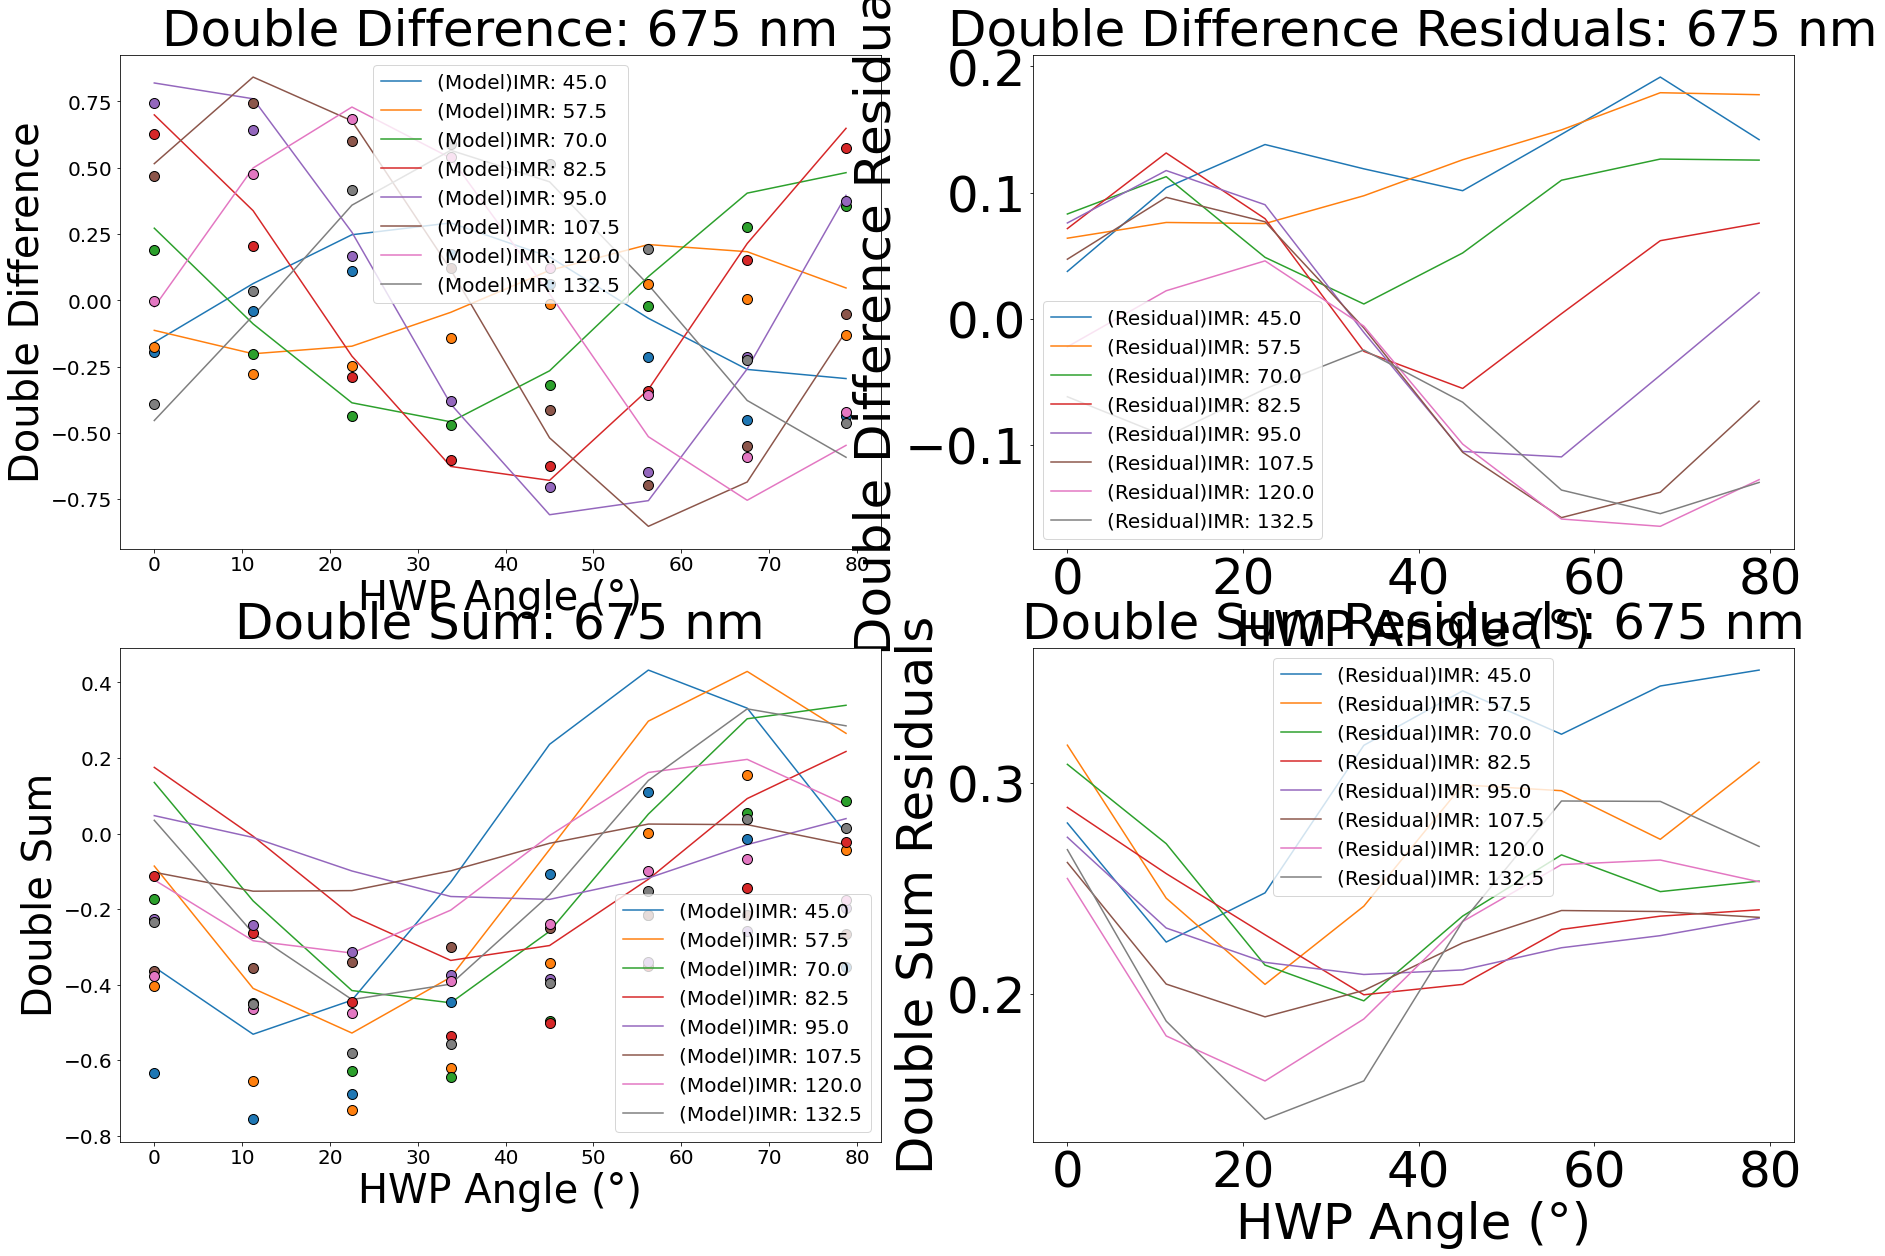

In [8]:
# Small value to remove error bars
log_f = -10

# Defining model angles
model_angles = np.linspace(0, 90, 100)

# # Defining lambda function
# nll = lambda *args: MCMC_SetUp.likelihood_linear_polarizer_residuals(*args)

# # List to store all the solutions 
# solns = []

# [ 0.44803965 -3.77683008  0.32872561 -0.14961975  0.32208685  0.45649444
#   1.5231767  -2.39509122  1.         -2.46183143  0.01868704]

initial_guess = np.array([
                    1 / 1.1373777834573546, # EM gain ratio
                    -2.663, # pol_theta (degrees)
                    0.302, # FLC_retardance (waves)
                    -0.163, # Optics_retardance (waves)
                    0.32, # IMR_retardance (waves)
                    0.451, # HWP_retardance (waves)
                    0.256, # FLC_angle (degrees)
                    -7.151, # Optics_angle (degrees)
                    -0.011, # IMR_offset (degrees)
                    -2.642, # HWP_offset (degrees)
                    0.036]) # Optics_diatteuation

theta_pol = -3.7768300814382085
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 1 / 1.1373777834573546  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# Trying the values from 1 degree bound IMR 5 degree others recursive notebook
# theta_pol = 0
# delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
# epsilon_m3 = 0 # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
# offset_m3 = 0 # NOTE: Made this zero too for testing purposes
# em_gain = 0.44803965482698693  # Add your actual em_gain value
# delta_HWP = 0.45649443676091783  # Add your actual delta_HWP value
# offset_HWP = -2.461831433780967  # Add your actual offset_HWP value
# delta_derot = 0.32208684844990476  # Add your actual delta_derot value
# offset_derot = 1  # Add your actual offset_derot value
# delta_opts = -0.14961975453168286  # Add your actual delta_opts value
# epsilon_opts = 0.01868703913240439  # Add your actual epsilon_opts value
# rot_opts = -2.3950912229452315  # Add your actual rot_opts value
# delta_FLC = 0.3287256097107294  # Add your actual delta_FLC value
# rot_FLC = 1.5231767001488516  # Add your actual rot_FLC value

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits - having zeros for angles that're too large
# em_gain = 0.423  # Add your actual em_gain value
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.642  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = -0.011  # Add your actual offset_derot value
# delta_opts = -0.163  # Add your actual delta_opts value
# epsilon_opts = 0.036  # Add your actual epsilon_opts value
# rot_opts = -7.151  # Add your actual rot_opts value
# delta_FLC = 0.302  # Add your actual delta_FLC value
# rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing specific parameters
# epsilon_m3 = epsilon_m3 / 1
# em_gain = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

fixed_params_with_soln = np.array([0, 0, 0] + list(soln.x[1 :]) + [em_gain])
initial_model = instrument_matrices.internal_calibration_mueller_matrix(soln.x[0],
    model, fixed_params_with_soln, HWP_angs, IMR_angs)

print(np.shape(initial_model))

initial_residuals = initial_model - reshaped_data

print(soln.x)
print(initial_model)

data_plotting.plot_single_model_and_residuals(angles, angles, initial_model, data, 
    initial_residuals, stds, log_f, wavelength, fig_dimensions = (30, 20))